In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import execute, Aer, circuit
from qiskit.converters import circuit_to_dag, dag_to_circuit

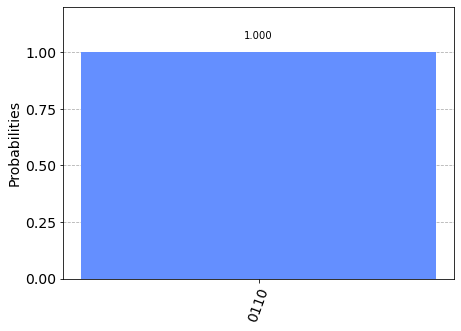

In [72]:
def mult_2(qc, n):
    for i in range(n):
        qc.cx(i, i + n)
    for i in range(n):
        qc.cx(i + n, i)
    for i in range(1, n):
        qc.cx(i + n - 1, i)
    for i in range(1, n):
        qc.cx(i, i + n - 1)

n = 4
qc = QuantumCircuit(QuantumRegister(n), QuantumRegister(n), ClassicalRegister(n))
qc.x(0) 
qc.x(1) #0011

mult_2(qc, n) #0110
qc.measure(range(n), range(n))
job = execute(qc, Aer.get_backend('qasm_simulator'), shots=100)
counts = job.result().get_counts(qc)
plot_histogram(counts)



In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import execute, Aer, circuit
#from qiskit.converters import circuit_to_dag, dag_to_circuit
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn import tree

In [8]:
def int_to_bin(int_numb, length):
    s = [0] * length
    i = 0
    while int_numb > 0:
        s[i] = int_numb % 2
        int_numb //= 2
        i += 1
    return s
#print(int_to_bin(3, 4))

In [35]:
def inc(qc, start_index, n_qbits):
    for i in range(start_index, start_index + n_qbits - 1):
        qc.mct(
            list(range(start_index, start_index + n_qbits - (i - start_index) - 1)), 
            start_index + n_qbits  - (i - start_index) - 1
        )
    qc.x(start_index)

In [36]:
"""
#старая версия
def mult_to_2(qc, start_index, n_qbits):
    n = n_qbits
    #for i in range(start_index, start_index + n): ???
    #    qc.cx(i, i + n)
    for i in range(start_index, start_index + n): #? check
        qc.cx(i + n, i) #обнуляю основной регистр
    for i in range(start_index + 1, start_index + n):
        qc.cx(i + n - 1, i) #двигаю биты вправо в основном регистре
    for i in range(start_index + 1, start_index + n):
        qc.cx(i, i + n - 1) #обнуляю вспомогательный регистр
"""
def mult_to_2(qc, start_index, n_qbits):
    for i in range(start_index + n_qbits - 1, 0, -1):
        qc.swap(i, i-1) #swap = x * 3


In [37]:
def change_node_index_gate(cur_ind, start_index, n_qbits, X, tree):
    qc = QuantumCircuit(n_qbits + 1)
    
    #если лист, достаем alpha
    if tree.feature[cur_ind] < 0:
        #поворачиваем 0-ой кубит на угол alpha
        qc.r(2 * tree.alpha[cur_ind], 0, 0) #????
    else:
        if X[tree.feature[cur_ind]] <= tree.threshold[cur_ind]:
            #идем в левого ребенка
            mult_to_2(qc, start_index, n_qbits)
            #inc(qc, start_index, n_qbits)
            #for i in range(start_index, start_index + n_qbits): #? check
            #    qc.cx(i, i + n_qbits) #вспомогательный регистр равен основному
        else:
            # идем в правого ребенка
            mult_to_2(qc, start_index, n_qbits)
            inc(qc, start_index, n_qbits)
            #inc(qc, start_index, n_qbits)
            #for i in range(start_index, start_index + n_qbits): #? check
            #    qc.cx(i, i + n_qbits) #вспомогательный регистр равен основному
    return qc.to_gate()
    

In [58]:
# n_of_qbits - для хранения индекса узла
# start_index - с какого кубита начинается хранения индекса числа
# X - объект, для которого предсказываем класс
# tree - дерево 
def tree_predict(qc, start_index=1, n_qbits, X, tree):
    n_nodes = tree.n_nodes 
    tree_height = math.log(n_nodes, 2)
    qc.x(start_index) #находимся в первом узле
    #цикл по количеству узлов
    for i in range(1, n_nodes): #id of nodes
        #если равен текущему индексу узла дерева, меняю на единицы
        bits = int_to_bin(i, n_qbits)
        for j in range(len(bits)):
            if bits[j] == 0:
                qc.x(start_index + j)    
        
        # если все единицы, проверяю условие, увеличиваю индекс текущего узла
        qc.mct(list(range(start_index, start_index + n_qbits)), start_index + n_qbits) # он будет контролирующий
        
        # отменяю отрицания, привожу к индексу        
        for j in range(len(bits)):
            if bits[j] == 0:
                qc.x(start_index + j)
        qc.append(
            change_node_index_gate(i, start_index, n_qbits, X, tree).control(), 
            [start_index + n_qbits] + list(range(start_index + n_qbits))
        )
        
        # если ушли в ребенка. левый и правый ребенок отличаются только в последнем кубите
        if i < 2 ** (height - 1):
            bits = int_to_bin(2 * i, n_qbits)
            for j in range(1, len(bits)):
                if bits[j] == 0:
                    qc.x(start_index + j) 
            #самый правый кубит обратно в 0
            qc.mct(list(range(start_index + 1, start_index + n_qbits)), start_index + n_qbits) 
            for j in range(1, len(bits)): #отменяю
                if bits[j] == 0:
                    qc.x(start_index + j) 
        else:
            #job = execute(qc,Aer.get_backend('statevector_simulator'),optimization_level=0)
            #current_quantum_state=job.result().get_statevector(qc)
            #print(current_quantum_state)
            for j in range(len(bits)):
                if bits[j] == 0:
                    qc.x(start_index + j)    
            qc.mct(list(range(start_index, start_index + n_qbits)), start_index + n_qbits) 
            # отменяю отрицания, привожу к индексу        
            for j in range(len(bits)):
                if bits[j] == 0:
                    qc.x(start_index + j)
       

In [39]:
import joblib
import sys
sys.path.insert(0, 'C:\\Users\\lilia\\PycharmProjects\\pythonProject\\ClassificationProblem-main')
from TreeClassification import *
import preprocessing
import math

In [40]:
tree = TreeClassification(joblib.load('C:\\Users\\lilia\\PycharmProjects\\pythonProject\\test\\joblib_model.pkl'))
tree.print_tree()

64


In [41]:
n_qbits = int(math.log2(tree.n_nodes))
start_index = 1
#X = [[0, 1, 2]] 
x_test, y_test = preprocessing.get_data("C:\\Users\\lilia\\PycharmProjects\\pythonProject\\ClassificationProblem-main\\data\\df_test.csv")
X = x_test.loc[89]

In [42]:
clf = joblib.load('C:\\Users\\lilia\\PycharmProjects\\pythonProject\\test\\joblib_model.pkl')
print(clf.predict_proba([X]))

[[0.76621881 0.23378119]]


In [43]:
qc = QuantumCircuit(QuantumRegister(start_index), QuantumRegister(n_qbits), QuantumRegister(1), ClassicalRegister(1))
tree_predict(qc, start_index, n_qbits, X, tree)

In [60]:
for i in range(10):
    X = x_test.loc[i]
    print(clf.predict_proba([X]))
    qc = QuantumCircuit(QuantumRegister(start_index), QuantumRegister(n_qbits), QuantumRegister(1), ClassicalRegister(1))
    tree_predict(qc, start_index, n_qbits, X, tree)
    qc.measure(0, 0)
    job = execute(qc, Aer.get_backend('qasm_simulator'), shots=100)
    counts = job.result().get_counts(qc)
    #plot_histogram(counts)
    print(counts['0'] / 100, counts['1'] / 100)
   

[[0.98970988 0.01029012]]
0.99 0.01
[[0.57142857 0.42857143]]
0.55 0.45
[[0.74067106 0.25932894]]
0.76 0.24
[[0.57142857 0.42857143]]
0.66 0.34
[[0.98970988 0.01029012]]
0.99 0.01
[[0.98970988 0.01029012]]
0.99 0.01
[[0.98970988 0.01029012]]
0.99 0.01
[[0.08527132 0.91472868]]
0.09 0.91
[[0.98970988 0.01029012]]
0.99 0.01
[[0.57142857 0.42857143]]
0.65 0.35
